# Sistemas Inteligentes

## Curso académico 2024-2025

### Laboratorio 2: Búsqueda Metaheurística

#### Instructores

* Juan Carlos Alfaro Jiménez: JuanCarlos.Alfaro@uclm.es
* María Julia Flores Gallego: Julia.Flores@uclm.es
* Ismael García Varea: Ismael.Garcia@uclm.es
* Adrián Rodríguez López: Adrian.Rodriguez18@alu.uclm.es

## Estaciones de Servicio y Energía: Encontrando la Configuración Óptima

## 1. Introducción

¡Noticias emocionantes! El **Ministerio de Transporte y Movilidad Sostenible** ha quedado muy impresionado con las soluciones desarrolladas en nuestro primer trabajo, la Práctica 1. Están particularmente interesados en implementar estos algoritmos en la planificación de rutas de vehículos autónomos, con A* como el método MÁS efectivo para identificar el camino óptimo de manera eficiente. Para avanzar en este proyecto, el Ministerio tiene como objetivo establecer estratégicamente estaciones de servicio en áreas urbanas para apoyar su flota de vehículos autónomos. Estas estaciones funcionarán como centros de flota y proporcionarán servicios esenciales para los vehículos.

Para lograr esto, han solicitado **nuestra experiencia técnica para determinar la distribución óptima de estas estaciones** en los mapas de la ciudad. Sin embargo, no todas las intersecciones son elegibles como ubicación de una estación; el Ministerio ha preseleccionado intersecciones candidatas basándose en criterios específicos establecidos por sus equipos técnicos y administrativos. Su principal enfoque es la sostenibilidad y el acceso equitativo, con el objetivo de garantizar que todos los ciudadanos estén razonablemente cerca de una estación de servicio. Entre estos puntos seleccionados, solo se elegirá un número específico. Para facilitar nuestra tarea de determinar cuáles deben ser, han proporcionado datos sobre la cobertura poblacional de cada intersección candidata, lo que nos permite tener en cuenta tanto el acceso como la cobertura en nuestra estrategia de distribución.

El objetivo principal es garantizar un acceso eficiente a la máxima población posible, manteniendo una distribución equilibrada en toda la ciudad, una consideración vital para un sistema de transporte completamente autónomo.

### 1.1 Objetivos del Laboratorio

En esta práctica, aplicaremos técnicas de búsqueda metaheurística para resolver problemas de optimización combinatoria.

El primer objetivo es comprender la tarea y formularla desde la perspectiva de la búsqueda metaheurística. Implementaremos al menos dos algoritmos:

* **Búsqueda Aleatoria**, como un punto de partida básico que generará múltiples soluciones, evaluará cada una y devolverá la mejor.

* **Algoritmo Genético**, que permitirá configurar varios parámetros, como el tamaño de la población, la tasa de mutación y el número de generaciones, entre otros.


Además, para la evaluación no-continua se tendrá que implementar la Ascensión de Cplinas o Hill Cilimbing (obligatoriamente), y opcionalmente implementar el algoritmo **Iterated Local Search** (ILS), ambos explicados en el Tema 7.

A continuación, analizaremos y compararemos el rendimiento de estos algoritmos ejecutándolos en instancias de problemas de diferente complejidad.

Esperamos que esta práctica te ayude a profundizar en tu comprensión de las técnicas metaheurísticas y te anime a considerar cómo se pueden aplicar en problemas reales de optimización combinatoria.

**¡Buena suerte!**

## 2. Descripción del Problema

### 2.1 Problemas de Entrada

Cada escenario se proporcionará en un archivo en formato `json` que contiene la siguiente información, con el formato de un diccionario cuyas claves son:

* `address`: La dirección utilizada.
* `distance`: Radio máximo utilizado para definir intersecciones y segmentos alrededor de la dirección.
* `intersections`: Una lista de diccionarios con información sobre las intersecciones.
* `segments`: Una lista de diccionarios con información sobre los segmentos, que representan las calles entre dos intersecciones.
* `candidates`: Una lista de pares (identificador, población) que contiene las intersecciones candidatas. Notad que los identificadores en esta lista deben estar incluidos en la lista de intersecciones.
* `number_stations`: El número de estaciones de servicio que se deben ubicar, que no debe superar el número de candidatos.

Cada diccionario en `intersections` incluye tres claves:

* `identifier`: Identificador de la intersección
* `longitude`: Longitud de la intersección
* `latitude`: Latitud de la intersección

Cada diccionario en `segments` incluye cuatro claves:

* `origin`: Intersección de origen
* `destination`: Intersección de destino
* `distance`: Distancia entre las dos intersecciones
* `speed`: Velocidad máxima permitida entre las dos intersecciones

**IMPORTANTE**: `initial` y `final` ya no están incluidos en el archivo JSON, ya que no son necesarios. Durante la evaluación de una posible configuración, estos puntos iniciales y finales cambiarán varias veces. Esto puede requerir algunos ajustes en el código de la Práctica 1 para ejecutar A*. Estos cambios deben estar claramente indicados (tu código debe coincidir con el de la Práctica 1, excepto por estos cambios) y discutidos en la memoria de prácticas.

### 2.2. Ejemplo ilustrativo

Un posible ejemplo de este problema podría ser el que se muestra en la siguiente imagen, que representa una parte de la ciudad de Albacete:

![title](p2/sample-problems-lab2/toy/example.png)

En este caso, el número de estaciones de servicio de vehículos que se deben ubicar es 4, entre las 15 intersecciones candidatas representadas con puntos azules (etiquetadas con la población cubierta). Una posible solución se representa con puntos verdes.

---

##### Nota:

* El archivo que contiene la imagen debe guardarse en la ruta indicada en el código de esta celda.

---

### 2.3 Definición formal del problema

Necesitamos elegir $s$ estaciones de entre $c$ intersecciones candidatas o elegibles, con $s<c$. Por lo tanto, nuestro objetivo es decidir en cuál de estas $c$ intersecciones candidatas debemos ubicar las $s$ estaciones de servicio de vehículos, de manera que se minimice el tiempo promedio de viaje que cada habitante tarda desde su hogar hasta la estación más cercana. Si denotamos por $S$ al vector de tamaño $s$ que contiene las intersecciones en las que se ubican las estaciones de vehículos y por $C$ al vector de intersecciones candidatas que contiene el par (id, pop) para cada intersección candidata, entonces formalmente, queremos resolver el siguiente problema de optimización:

$$
S^* = \arg\min_{S} \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot \sum_{i=0}^{c-1} \; C[i].pop \cdot \min_{j=0,\dots,s-1} \big\{time(C[i].id,S[j])\big\}
$$

donde:
- $C[i].pop$ representa la población (número de habitantes) cubierta por la intersección candidata $i$.
- $C[i].id$ es el identificador de la intersección candidata $i$.
- $time(A,B)$ representa el menor tiempo real para viajar desde la intersección $A$ hasta la intersección $B$.
- $S$ contiene exactamente $s$ intersecciones distintas, que deben pertenecer todas al conjunto de soluciones candidatas, y siendo $s<=c$

Las siguientes consideraciones deben tenerse en cuenta respecto a la expresión anterior:
- Estamos tratando con un problema de minimización.
- La cardinalidad del espacio de búsqueda es:

$$
\binom{c}{s} = \frac{c!}{(c-s)!s!}
$$

por ejemplo, si tenemos 20 intersecciones elegibles y 4 estaciones de vehículos, el número de soluciones posibles es 210, no demasiadas; pero si tenemos 100 candidatos y 10 estaciones, entonces el número de soluciones posibles es $1.7\times10^{13}$ ($5.3\times 10^{20}$ con 20 estaciones).

## 3. Desarrollo de la práctica

Antes de implementar los algoritmos, primero debes considerar definir los elementos básicos en este tipo de problemas, a saber:

- Una representación conveniente para las soluciones (configuraciones, cromosomas, individuos, ...) del problema que se utilizarán en los algoritmos de optimización combinatoria. Piensa detenidamente en las distintas opciones y tendrás que discutirlas en el informe de la tarea.

- Implementar un mecanismo de evaluación para gestionar las evaluaciones realizadas por los algoritmos de optimización combinatoria. A continuación, se detallará cómo debe realizarse la evaluación.

- Notas importantes:
    - En el caso de que A* no devuelva ninguna solución (coste = inf), reemplazad este valor por un número muy alto en comparación con el tiempo máximo en nuestro problema. Reflexiona sobre la necesidad de esto y discútelo en el informe.
    - Podéis aprovechar el mecanismo de evaluación para guardar algunos cálculos, recopilar estadísticas e imprimir los resultados.
    - Tened en cuenta que esta tarea requiere que ya hayas resuelto la Práctica 1, y necesitarás reutilizar el código implementado para resolver esta práctica.
   
Tendréis que resolver muchos problemas similares a los de la Práctica 1. Los mapas serán los mismos, pero los problemas necesitan incorporar nueva información, que es la lista de intersecciones candidatas y, para cada una de ellas, la población que cubren. El número de estaciones que se deben ubicar también se indica en el problema como `number_stations`.


### 3.1 Evaluación de una solución

Dada una instancia específica del problema a resolver, y asumiendo que $C$ denota su lista de intersecciones candidatas, el valor de cada posible solución $S$ debe calcularse como:

$$value(S) = \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot \sum_{i=0}^{c-1} \; C[i].pop \cdot \min_{j=0,\dots,s-1} \big\{ time(C[i].id,S[j])\big\}$$

de acuerdo con la fórmula presentada en la sección 2.2.

## 4. Plan de trabajo

### 4.1. Tareas

* Transferid y adaptad vuestro código de la Práctica 1 para resolver búsquedas con A* que necesitaréis aquí:
    * Reutilizad la mayor parte del código necesario de vuestra Práctica 1.
    * Describid qué se ha modificado, por qué y cómo.

* Procesad los nuevos archivos JSON y guardad el problema de acuerdo con lo siguiente:
    * Además de las clases de búsqueda (Problem_2, State, Action, ...), deberéis trabajar con las intersecciones candidatas.
    * Construid un mecanismo capaz de almacenar y recuperar las intersecciones candidatas y la población asociada a cada una.

* Representación de una posible configuración:
    * Entre las vistas en el Tema 6, encontrad la representación más adecuada para este problema y adaptadla, teniendo en cuenta que cada problema tiene valores distintos para el número total de intersecciones, intersecciones elegibles y el número solicitado de estaciones.
    * Conectadla a un método adecuado para evaluar cada una considerando las indicaciones mencionadas anteriormente en el punto 3.2.

* Implementación de algoritmos:
    * Implementad, al menos, los dos algoritmos requeridos (Búsqueda Aleatoria y un Algoritmo Genético — GA). Tened en cuenta que para la evaluación no continua, también deberéis agregar Hill Climbing y, opcionalmente, ILS.
    * En el GA, aseguraos de haber implementado la generación de una población junto con los elementos principales dentro del bucle principal: selección, cruce, mutación y combinación de generaciones.

* Experimentación y análisis:
    * Los parámetros que se puedan ajustar deben ser explorados adecuadamente, también en relación con los problemas dados (dimensionalidad, complejidad, etc.).
    * También deberéis estudiar el rendimiento resultante en términos de desempeño, convergencia, número de generaciones, etc.
    * Comparad la Búsqueda Aleatoria y el Algoritmo Genético, asegurándoos de obtener resultados consistentes.

* Informe:
    * Redactad un informe detallando el proceso seguido, las estrategias implementadas y los resultados obtenidos, junto con gráficos y comparaciones visuales.


### 4.2. Evaluación de la práctica

En la modalidad de **evaluación continua**, la evaluación de la práctica se realizará a través de un examen individual en el que se tendrá en cuenta lo siguiente:

* Definición e implementación correcta de la representación de la configuración y de la función de evaluación: 25%
* Implementación correcta del algoritmo genético: 50%, que cubre
    * El bucle general para las generaciones es correcto: 10%
    * Los distintos operadores están correctamente diseñados y codificados: 40%
* Eficiencia y optimización: 15%
* Experimentación realizada y análisis de resultados: 10%

Es necesario que la Práctica 1 esté correctamente integrada y que la Búsqueda Aleatoria funcione de manera consistente para que todos los estudiantes puedan utilizarla como un punto de partida base adecuado.

Todo esto se ponderará según el nivel de conocimiento que el estudiante demuestre sobre la práctica en caso de que el examen sea una entrevista personal.

En la modalidad de **evaluación no continua**, la evaluación se modificará como se indica a continuación:

* Definición e implementación correcta de la representación de la configuración y de la función de evaluación: 15%
* Implementación correcta del algoritmo genético: 40%, que cubre
    * El bucle general para las generaciones es correcto: 7%
    * Los distintos operadores están correctamente diseñados y codificados: 33%
* Implementación correcta del algoritmo de Hill Climbing (obligatorio): 15%
* Implementación correcta del algoritmo ILS (opcional): 5%
* Eficiencia y optimización: 15%
* Experimentación realizada y análisis de resultados: 10%


### 4.3. Fechas importantes

* Fecha límite para entregar el código: **13 de diciembre de 2024**.
* Fecha límite para la entrega del informe: **Final del semestre**.


In [485]:
  #Imports
import json
import math
import queue
import timeit
import random
from abc import abstractmethod, ABC

In [486]:
class Accion:
    def __init__(self, origen, destino, coste):
        self.origen = origen
        self.destino = destino
        self.costeAccion = coste

    def __repr__(self):
        return f"Accion: {self.origen} --({self.coste})--> {self.destino}"

In [487]:
class Estado:

    def __init__(self, id, longitud, latitud):
        self.id = id
        self.longitud = longitud
        self.latitud = latitud

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, otro):
        return self.id == otro.id

    def __repr__(self):
        return f"Estado: {self.id}, {self.longitud}, {self.latitud}"

In [488]:
import json
import queue
from collections import defaultdict
class Problema:
    def __init__(self, nombre_archivo):
        with open(nombre_archivo, 'r') as archivo:
            problema = json.load(archivo)

        self.inicio = None
        self.final = None
        self.acciones = defaultdict(list)
        self.estados = {}
        self.velMax = 0

        for inter in problema['intersections']:
            self.estados[inter['identifier']] = Estado(
                inter['identifier'],
                inter['longitude'],
                inter['latitude']
            )

        self.estadoInicial = None
        self.estadoFinal = None

        for seg in problema['segments']:
            origen = seg['origin']
            destino = seg['destination']
            vel = seg['speed']/3.6
            tiempo = seg['distance'] / vel
            self.velMax = max(self.velMax, seg['speed'])
            self.acciones[origen].append(Accion(origen, destino, tiempo))
        for origen in self.acciones:
            self.acciones[origen].sort(key=lambda x: x.destino)

        self.candidatos = tuple(problema['candidates'])
        self.numeroEstaciones = problema['number_stations']

In [489]:
class Nodo:

    def __init__(self, estado = None, accion = None, padre = None, costeAcumulado = 0.0):
        self.estado = estado
        self.accion = accion
        self.padre = padre
        self.costeAcumulado = costeAcumulado

    def __repr__(self):
        padre_id = self.padre.estado.id if self.padre is not None else None
        return f"Nodo(id={self.estado.id}, longitud={self.estado.longitud}, latitud={self.estado.latitud}, padre={padre_id}, costeAcumulado={self.costeAcumulado})"

    def __eq__(self, otro):
        return isinstance(otro, Nodo) and self.estado == otro.estado

    def __hash__(self):
        return hash(self.estado)

    def __lt__(self, otro):
        return self.estado.id < otro.estado.id


In [490]:
from geopy.distance import geodesic

def heuristica_geodesica(estadoPresente, estadoMeta, velMax):

    coord1 = (estadoPresente.latitud, estadoPresente.longitud)
    coord2 = (estadoMeta.latitud, estadoMeta.longitud)

    distancia_metros = geodesic(coord1, coord2).meters
    velocidad_mps = velMax / 3.6

    return distancia_metros / velocidad_mps


In [491]:
from datetime import timedelta
class Busqueda(ABC):

    def __init__(self, nombre_archivo):
        self.problema = Problema(nombre_archivo)
        self.listaExpantidos = set()
        self.listaAbiertos = []
        self.generados = 0
        self.expandidos = 0

    @abstractmethod
    def insertarNodo(self, nodo, listaNodos):
        pass

    @abstractmethod
    def extraerNodo(self, listaNodos):
        pass

    @abstractmethod
    def vacio(self, listaNodos):
        pass

    def buscar(self, inicio, final):
        self.listaAbiertos.clear()
        listaExpandidos = set()
        self.generados = 0
        expandidos = 0
        generados = 0
        self.problema.inicio = inicio
        self.problema.final = final
        eInicial = self.problema.estados[inicio]
        eFinal = self.problema.estados[final]
        self.problema.estadoInicial = eInicial
        self.problema.estadoFinal = eFinal

        self.listaAbiertos = self.insertarNodo(Nodo(self.problema.estadoInicial), self.listaAbiertos)

        while not self.vacio(self.listaAbiertos):
            nodo = self.extraerNodo(self.listaAbiertos)

            if nodo not in listaExpandidos:
                listaExpandidos.add(nodo)

                if nodo.estado == self.problema.estadoFinal:
                    return nodo.costeAcumulado

                acciones = self.problema.acciones[nodo.estado.id]
                for accion in acciones:
                    nuevo_nodo = Nodo(
                        self.problema.estados[accion.destino],
                        accion,
                        nodo,
                        nodo.costeAcumulado + accion.costeAccion
                    )
                    generados += 1
                    self.insertarNodo(nuevo_nodo, self.listaAbiertos)
                expandidos += 1

        return 3600 * 5

In [492]:
import heapq
class AEstrella(Busqueda):

    def __init__(self, nombre_archivo):
        super().__init__(nombre_archivo)
        #self.listaAbiertos = queue.PriorityQueue()

    def insertarNodo(self, nodo, listaNodos):
        g = nodo.costeAcumulado
        vel = 1
        h = heuristica_geodesica(nodo.estado, self.problema.estadoFinal, self.problema.velMax)
        f = g + h
        #listaNodos.put((f, nodo))
        heapq.heappush(listaNodos, (f, nodo))
        return listaNodos

    def extraerNodo(self, listaNodos):
        return heapq.heappop(listaNodos)[1]

    def vacio(self, listaNodos):
        return len(listaNodos) == 0

In [493]:
import random
from datetime import timedelta
import matplotlib.pyplot as plt

class BusquedaAleatoria:
    def __init__(self, nombre_archivo, caching=True):
        self.problema = Problema(nombre_archivo)
        self.a_estrella = AEstrella(nombre_archivo)
        self.listaCandidatosCaching = {}
        self.valoresAlmacenados = {}
        self.caching = caching
        self.contadorllamadas = 0
        self.mejoresIndividuos = []
        self.mejorTiempoMedio = 0
        self.historial = []  # Para graficar evolución

    def aEstrellaCaching(self, origen, destino):
        if self.caching:
            ruta = (origen, destino)
            if ruta in self.valoresAlmacenados:
                tiempo = self.valoresAlmacenados[ruta]
            else:
                self.contadorllamadas += 1
                tiempo = self.a_estrella.buscar(origen, destino)
                self.valoresAlmacenados[ruta] = tiempo
        else:
            self.contadorllamadas += 1
            tiempo = self.a_estrella.buscar(origen, destino)
        return tiempo

    def buscar(self, semilla, numeroVuelas):
        random.seed(semilla)
        mejorTiempoMedio = 10**10
        self.historial = []  # Reinicia historial por si se reutiliza la instancia

        for contador in range(numeroVuelas):
            print(f"Generación {contador+1:3d}", end=' │ ')
            aleatorio = tuple(random.sample(self.problema.candidatos, self.problema.numeroEstaciones))
            tiempo_betha = 0.0
            poblacion_total = 0.0

            for interseccion in self.problema.candidatos:
                minimo = 3600 * 5
                origen = interseccion[0]
                peso_poblacion = interseccion[1]

                for x in aleatorio:
                    destino = x[0]
                    tiempo = self.aEstrellaCaching(origen, destino)
                    if tiempo < minimo:
                        minimo = tiempo

                tiempo_betha += peso_poblacion * minimo
                poblacion_total += peso_poblacion

            if poblacion_total > 0:
                resultado = tiempo_betha / poblacion_total
                self.historial.append(resultado)

                if resultado < mejorTiempoMedio:
                    self.mejoresIndividuos = [x[0] for x in aleatorio]
                    mejorTiempoMedio = resultado

                self.mejorTiempoMedio = mejorTiempoMedio

                # Mostrar tiempo en formato legible
                td = timedelta(seconds=mejorTiempoMedio)
                total_segundos = int(td.total_seconds())
                horas = total_segundos // 3600
                minutos = (total_segundos % 3600) // 60
                segundos = total_segundos % 60
                milisegundos_4 = int((mejorTiempoMedio - total_segundos) * 10_000)

                print(f"Mejor tiempo medio: {mejorTiempoMedio:.6f} ({horas:02}:{minutos:02}:{segundos:02}:{milisegundos_4:04})")

    def graficar_resultados(self):
        if not self.historial:
            print("No hay resultados para graficar.")
            return

        generaciones = list(range(len(self.historial)))
        fitness = self.historial

        plt.figure(figsize=(10, 5))
        plt.plot(generaciones, fitness, marker='o', color='darkgreen', linestyle='-')
        plt.title('Evolución del Mejor Fitness por Generación')
        plt.xlabel('Generación')
        plt.ylabel('Mejor Fitness')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [494]:
import random
import sys
import matplotlib.pyplot as plt

class AlgoritmoGenetico:
    def __init__(self, busqueda_aleatoria, tam_poblacion, prob_cruce, prob_mutacion, max_generaciones):
        self.ba = busqueda_aleatoria
        self.tam_poblacion = self.ba.problema.numeroEstaciones
        self.prob_cruce = prob_cruce
        self.prob_mutacion = prob_mutacion
        self.max_generaciones = max_generaciones
        self.num_candidatos = len(self.ba.problema.candidatos)
        self.estaciones_requeridas = self.ba.problema.numeroEstaciones
        self.listaFitnessGeneracion = []

    def generar_individuo(self):
        indices = random.sample(range(self.num_candidatos), self.estaciones_requeridas)
        individuo = [0] * self.num_candidatos
        for i in indices:
            individuo[i] = 1
        return individuo

    def evaluar(self, individuo):
        if sum(individuo) != self.estaciones_requeridas:
            return 10**10

        tiempo_betha = 0.0
        pop_total = 0.0

        for interseccion in self.ba.problema.candidatos:
            minimo = sys.float_info.max
            origen = interseccion[0]
            peso_poblacion = interseccion[1]

            for i, bit in enumerate(individuo):
                if bit == 1:
                    destino = self.ba.problema.candidatos[i][0]
                    tiempo = self.ba.aEstrellaCaching(origen, destino)
                    if tiempo < minimo:
                        minimo = tiempo

            tiempo_betha += peso_poblacion * minimo
            pop_total += peso_poblacion

        return tiempo_betha / pop_total

    def seleccionar(self, poblacion, fitnesses, k=3):
        seleccionados = []
        for _ in range(len(poblacion)):
            aspirantes = random.sample(list(zip(poblacion, fitnesses)), k)
            mejor = min(aspirantes, key=lambda x: x[1])
            seleccionados.append(mejor[0])
        return seleccionados

    def cruzar(self, p1, p2):
        if random.random() < self.prob_cruce:
            punto = random.randint(1, len(p1) - 1)
            h1 = p1[:punto] + p2[punto:]
            h2 = p2[:punto] + p1[punto:]
            return h1, h2
        else:
            return p1[:], p2[:]

    def mutar(self, individuo):
        for i in range(len(individuo)):
            if random.random() < self.prob_mutacion:
                individuo[i] = 1 - individuo[i]
        return individuo

    def reparar(self, individuo):
        activos = [i for i, bit in enumerate(individuo) if bit == 1]
        inactivos = [i for i, bit in enumerate(individuo) if bit == 0]

        if len(activos) > self.estaciones_requeridas:
            apagar = random.sample(activos, len(activos) - self.estaciones_requeridas)
            for i in apagar:
                individuo[i] = 0
        elif len(activos) < self.estaciones_requeridas:
            encender = random.sample(inactivos, self.estaciones_requeridas - len(activos))
            for i in encender:
                individuo[i] = 1
        return individuo

    def algoritmo(self):
        poblacion = [self.generar_individuo() for _ in range(self.tam_poblacion)]
        lista_deFitness = [self.evaluar(indi) for indi in poblacion]

        for generacion in range(self.max_generaciones + 1):
            mejor_fitness = min(lista_deFitness)
            print(f"Generación {generacion:3d} │ Mejor fitness: {mejor_fitness:.6f}")
            self.listaFitnessGeneracion.append({'gen': generacion, 'mejor': mejor_fitness})

            seleccionados = self.seleccionar(poblacion, lista_deFitness)
            nueva_pob = []

            for i in range(0, self.tam_poblacion, 2):
                p1 = seleccionados[i]
                p2 = seleccionados[(i + 1) % self.tam_poblacion]
                h1, h2 = self.cruzar(p1, p2)
                h1 = self.reparar(self.mutar(h1))
                h2 = self.reparar(self.mutar(h2))
                nueva_pob.extend([h1, h2])

            poblacion = nueva_pob
            lista_deFitness = [self.evaluar(ind) for ind in poblacion]

        mejor_idx = lista_deFitness.index(min(lista_deFitness))
        mejor_individuo = poblacion[mejor_idx]
        return mejor_individuo, lista_deFitness[mejor_idx], self.decodificar(mejor_individuo)

    def decodificar(self, individuo):
        return [self.ba.problema.candidatos[i] for i, bit in enumerate(individuo) if bit == 1]

    def graficar_evolucion(self):
        generaciones = [g['gen'] for g in self.listaFitnessGeneracion]
        fitness = [g['mejor'] for g in self.listaFitnessGeneracion]

        plt.figure(figsize=(10, 5))
        plt.plot(generaciones, fitness, marker='o', color='darkgreen', linestyle='-')
        plt.title('Evolución del Mejor Fitness por Generación')
        plt.xlabel('Generación')
        plt.ylabel('Mejor Fitness')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Generación   1 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   2 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   3 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   4 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   5 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   6 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   7 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   8 │ Mejor tiempo medio: 15.027319 (00:00:15:0273)
Generación   9 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  10 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  11 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  12 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  13 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  14 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  15 │ Mejor tiempo medio: 12.311254 (00:00:12:3112)
Generación  16 │ Mejor tiempo medio: 12.311254 (00:00:1

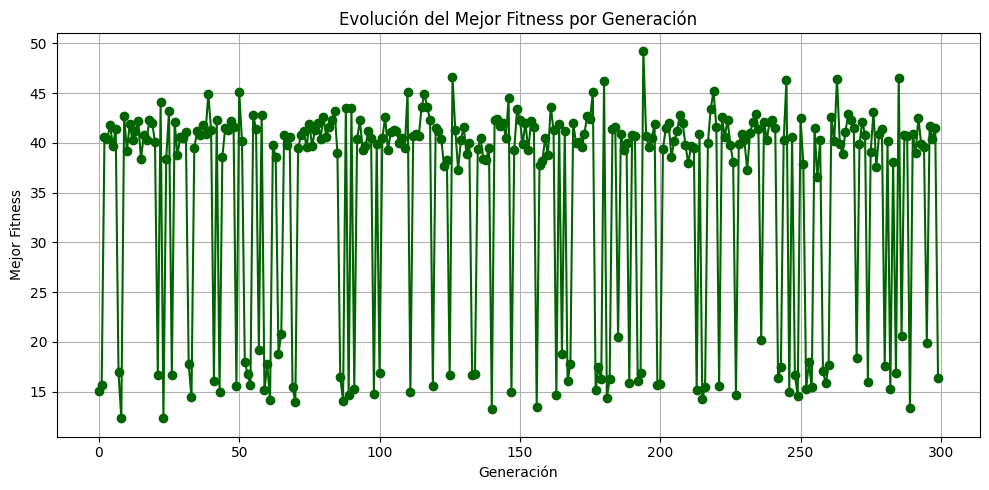

Generación   0 │ Mejor fitness: 13.954429
Generación   1 │ Mejor fitness: 13.789831
Generación   2 │ Mejor fitness: 13.517405
Generación   3 │ Mejor fitness: 13.957915
Generación   4 │ Mejor fitness: 13.654495
Generación   5 │ Mejor fitness: 14.044494
Generación   6 │ Mejor fitness: 14.750625
Generación   7 │ Mejor fitness: 13.905174
Generación   8 │ Mejor fitness: 14.466220
Generación   9 │ Mejor fitness: 12.893423
Generación  10 │ Mejor fitness: 13.615261
Generación  11 │ Mejor fitness: 14.928592
Generación  12 │ Mejor fitness: 15.624692
Generación  13 │ Mejor fitness: 15.289992
Generación  14 │ Mejor fitness: 16.368933
Generación  15 │ Mejor fitness: 13.831565
Generación  16 │ Mejor fitness: 15.315380
Generación  17 │ Mejor fitness: 14.063041
Generación  18 │ Mejor fitness: 13.041381
Generación  19 │ Mejor fitness: 14.715415
Generación  20 │ Mejor fitness: 14.133743
Generación  21 │ Mejor fitness: 14.860892
Generación  22 │ Mejor fitness: 13.474345
Generación  23 │ Mejor fitness: 14

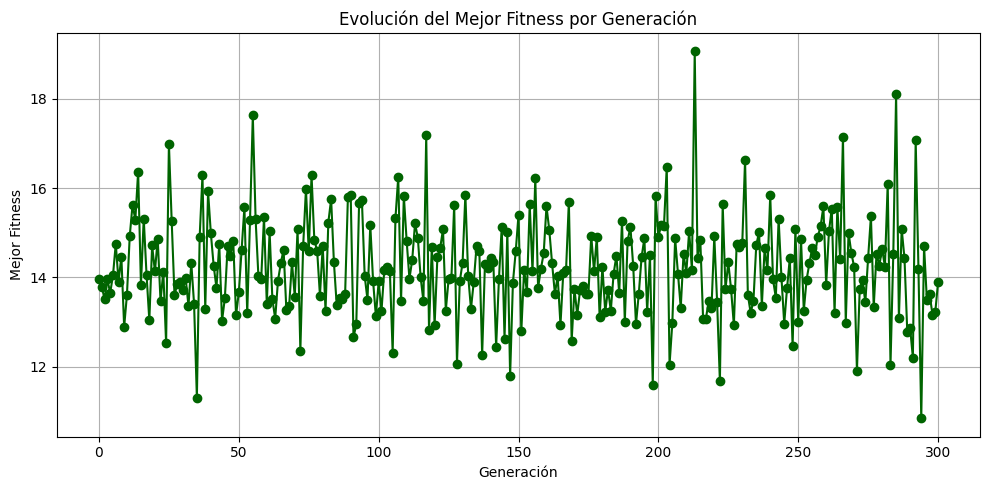

96.1277289390564
101.67511296272278
Tiempo final 1: 00:01:36.127
Tiempo final 2: 00:01:41.675


In [495]:
import time
if __name__ == "__main__":
    nombre_archivo =\
        r"C:\Users\pasat\OneDrive\Desktop\Inteli\Prac2\sample-problems-lab2\medium\calle_agustina_aroca_albacete_500_1_candidates_89_ns_22.json"
    num_iteraciones = 1
    resultados_aleatorio = []
    resultados_genetico = []

    random.seed(7)
    z = BusquedaAleatoria(nombre_archivo, caching=True)
    inicio = time.time()
    resultado = z.buscar(7, 300)
    z.graficar_resultados()
    tiempo_final = time.time() - inicio

    z_ag = BusquedaAleatoria(nombre_archivo, caching=True)
    ag = AlgoritmoGenetico(z_ag, 50, 0.75, 0.5, 300)
    inicio = time.time()
    ag.algoritmo()
    ag.graficar_evolucion()
    tiempo_final2 = time.time() - inicio

    #
    #Mostrar tiempo
    #
    print(tiempo_final)
    print(tiempo_final2)

    def mostrar_tiempo_legible(segundos):
        td = timedelta(seconds=segundos)
        total_segundos = int(td.total_seconds())

        horas = total_segundos // 3600
        minutos = (total_segundos % 3600) // 60
        segundos_restantes = total_segundos % 60
        milisegundos = int((segundos - total_segundos) * 1000)
        return f"{horas:02}:{minutos:02}:{segundos_restantes:02}.{milisegundos:03}"

    print("Tiempo final 1:", mostrar_tiempo_legible(tiempo_final))
    print("Tiempo final 2:", mostrar_tiempo_legible(tiempo_final2))

